In [2]:
%pylab inline
%config InlineBackend.figure_format = 'svg' 

Populating the interactive namespace from numpy and matplotlib


In [3]:
import group_data as gd
import flylib
import pylab as plb

In [4]:
swarm_data = dict()
for key in gd.swarms.keys():
    paths = dict()
    for fly in gd.swarms[key].flies:
        paths[fly.fly_num] =  {'fly_path':fly.fly_path,'fly_num':fly.fly_num}
    swarm_data[key] = paths

In [5]:
def get_line_database(line_name):
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

In [6]:
def get_signal_dict(fly_path):
    import h5py
    import cPickle
    import numpy as np
    muscle_data_file = fly_path+'nnls_fits_no_bk_dF_F.cpkl'
    fly_record_file = fly_path+'fly_record.hdf5'
    signal_dict = dict()
    fi = open(muscle_data_file,'rb')
    muscle_data = cPickle.load(fi)
    fi.close()
    for mu,sig in zip(muscle_data['muscles'],muscle_data['fits']):
        signal_dict[mu] = sig
    hf = h5py.File(fly_record_file,'r')
    exp_record = hf['experiments'].values()[0]
    for key in exp_record['tiff_data']['axon_framebase'].keys():
        signal_dict[key] = np.array(exp_record['tiff_data']['axon_framebase'][key])
    hf.close()
    return signal_dict

In [7]:
for swarm in swarm_data.values():
    for flykey in swarm.keys():
        fly = swarm[flykey]
        try:
            #print fly['fly_num']
            fly['sigs'] = get_signal_dict(fly['fly_path'])
        except IOError as er:
            print flykey
            swarm.pop(flykey)
            print er

313
[Errno 2] No such file or directory: '/media/FlyDataC/FlyDB/Fly0313/nnls_fits_no_bk_dF_F.cpkl'


In [8]:
def get_muscle_list(line_name):
    """function to get list of muscles for a given line 
    should make this general and move to src/ """
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

def map_cross_cors(fly_num,sigs,muscle_list):
    """parallel function to calculate cross correlations""" 
    def calc_cross_cors(sigs,muscle_list):
        import flylib
        import numpy as np
        #reload(flylib)
        amp_corr_dict = dict()
        freq_corr_dict = dict()
        auto_corr_dict = dict()
        import flylib
        rwing = flylib.butter_bandpass_filter(sigs['Ph1'],0.02,20.0,0.022,order = 1)
        wbf = sigs['wb_frequency']
        wbf_filt = flylib.butter_bandpass_filter(wbf,0.02,20.0,0.022,order = 1)
        StimCond = sigs['StimCond']
        imlen = np.shape(sigs[muscle_list[0]])[0]
        mask = ((StimCond<0) & (wbf >150))[:imlen]
        times = sigs['times']
        dt = (times[1]-times[0])
        xcor_times = np.arange(0,np.sum(mask))*dt - dt*np.sum(mask)/2
        from scipy import signal
        for mname in muscle_list:
            if not('ps' in mname):
                msig = flylib.butter_bandpass_filter(sigs[mname],0.02,20.0,0.022,order = 1)
                amp_corr_dict[mname] = signal.correlate(msig[mask],rwing[mask],mode = 'same')
                freq_corr_dict[mname] = signal.correlate(msig[mask],wbf_filt[mask],mode = 'same')
                auto_corr_dict[mname] = signal.correlate(msig[mask],msig[mask],mode = 'same')
        return {'amp':amp_corr_dict,'freq':freq_corr_dict,'auto':auto_corr_dict,'times':xcor_times}
    return {fly_num:calc_cross_cors(sigs,muscle_list)}

In [9]:
#create a tuple of arguments to pass to the map function
map_data = dict()
for swarmkey in swarm_data.keys():
    muscle_list = get_muscle_list(swarmkey)
    map_data[swarmkey] = ([key for key in swarm_data[swarmkey].keys()],
                           [swarm_data[swarmkey][key]['sigs'] for key in swarm_data[swarmkey].keys()],
                           [muscle_list for key in swarm_data[swarmkey].keys()])

In [10]:
#get the ipython clients
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
#map in chunks by swarm
output_dict = dict()
for swarmkey in swarm_data.keys():
    print swarmkey
    output_dict[swarmkey] = v.map(map_cross_cors,*map_data[swarmkey])

In [ ]:
#load the computed data back into the swarm_data dictionary
for swarmkey in swarm_data.keys():
    for i,fnum in enumerate([x.keys()[0] for x in output_dict[swarmkey]]):
        swarm_data[swarmkey][fnum]['corr_data'] =  output_dict[swarmkey][i].values()[0]

In [ ]:
#save the dictionary as a pickle (need to write that dict to hdf5 wrapper)
import cPickle
f = open('extracted_sigs.cpkl','wb')
for swarmkey in swarm_data.keys():
    for fly in swarm_data[swarmkey].values():
        print fly['fly_path']
        print fly.keys()
        data_path =  fly['fly_path'] + 'nnls_fits_no_bk_dF_F_corr_data.cpkl'
        f = open(data_path,'wb')
        cPickle.dump(fly['corr_data'],f)
        f.close()

In [ ]:
#notify me that the batch is done
import smtplib
server = smtplib.SMTP( "smtp.gmail.com", 587 )
server.starttls()
server.login( 'thlindsay1@gmail.com', 'cyp4501a1' )
server.sendmail( 'test', '5412229957@txt.att.net', 'batch processing done' )

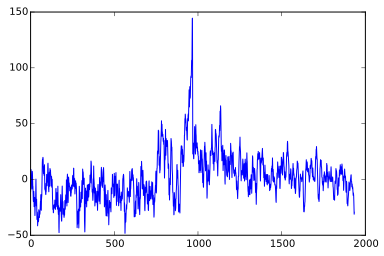

In [25]:
plb.plot(swarm_data['GMR31E10'][337]['corr_data']['amp']['iii3'][::10])

In [27]:
ls -al /media/FlyDataC/FlyDB/Fly*/nnls_fits_no_bk_dF_F_corr_data.cpkl

-rw-rw-r-- 1 psilentp psilentp 24723725 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0308/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 15948812 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0309/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 17197654 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0310/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 21733728 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0311/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 21131098 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0312/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 15797300 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0314/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 20730282 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0315/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 21500469 Apr 15 01:33 /media/FlyDataC/FlyDB/Fly0316/nnls_fits_no_bk_dF_F_corr_data.cpkl
-rw-rw-r-- 1 psilentp psilentp 21592435 Apr 15 0

In [ ]:
#load the computed data back into the swarm_data dictionary
for swarmkey in swarm_data.keys():
    for i,fnum in enumerate([x.keys()[0] for x in output_dict[swarmkey]]):
        swarm_data[swarmkey][fnum]['corr_data'] =  output_dict[swarmkey][i].values()[0]

#save the dictionary as a pickle (need to write that dict to hdf5 wrapper)
import cPickle
f = open('extracted_sigs.cpkl','wb')
for swarmkey in swarm_data.keys():
    for fly in swarm_data[swarmkey].values():
        print fly['fly_path']
        print fly.keys()
        data_path =  fly['fly_path'] + 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl'
        f = open(data_path,'wb')
        cPickle.dump(fly['sig_mtrx'],f)
        f.close()
        
        data_path =  fly['fly_path'] + 'nnls_fits_no_bk_dF_F_corr_data.cpkl'
        f = open(data_path,'wb')
        cPickle.dump(fly['corr_data'],f)
        f.close()
        
        data_path =  fly['fly_path'] + 'nnls_fits_no_bk_dF_F_sigs.cpkl'
        f = open(data_path,'wb')
        cPickle.dump(fly['sigs'],f)
        f.close()